# LSTM Model

In [2]:
import yfinance as yf

# Fetch Yahoo Finance Bitcoin Data with 15-minute interval
btc_data_15m = yf.download(tickers='BTC-USD', period='60d', interval='15m')

# Display the loaded data
print(btc_data_15m)

[*********************100%***********************]  1 of 1 completed
                             Open          High           Low         Close  \
Datetime                                                                      
2024-02-13 00:00:00  49941.359375  50008.179688  49937.214844  49994.460938   
2024-02-13 00:15:00  49986.019531  50065.500000  49984.429688  50065.500000   
2024-02-13 00:30:00  50138.128906  50145.027344  50031.691406  50046.171875   
2024-02-13 00:45:00  50046.710938  50147.093750  50046.710938  50102.671875   
2024-02-13 01:00:00  50110.898438  50221.207031  50110.898438  50178.636719   
...                           ...           ...           ...           ...   
2024-04-12 15:45:00  69389.328125  69452.710938  69312.445312  69374.898438   
2024-04-12 16:00:00  69343.828125  69530.734375  69185.460938  69187.585938   
2024-04-12 16:15:00  69124.539062  69124.539062  68709.828125  69029.914062   
2024-04-12 16:30:00  68970.867188  68970.867188  68677.085938 

## Backtesting LSTM Trading Model

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

# Load the saved LSTM model
model = load_model("Final_LSTM%.h5")

# Prepare the data for backtesting
features = btc_data_15m['Adj Close'].values.reshape(-1, 1)

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Define the sequence length
sequence_length = 4

# Create sequences
x_test = []
y_test = []
for i in range(sequence_length, len(features_scaled)):
    x_test.append(features_scaled[i-sequence_length:i, 0])
    y_test.append(features_scaled[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape x_test to match the input shape of the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions on the test data
y_pred = model.predict(x_test)

# Reshape y_test and y_pred arrays
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# Inverse transform to get actual prices
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Simulate trading
initial_balance = 10000  
balance = initial_balance
btc_held = 0

transaction_times = []  # Store transaction times
transaction_types = []  # Store transaction types

# Trading Logic
for i in range(len(y_pred)):
    current_price = y_test_inv[i][0]
    predicted_price = y_pred_inv[i][0]
    transaction_time = btc_data_15m.index[i]

    if predicted_price > current_price and balance > 0:
        # Buy BTC
        btc_held += balance / current_price
        balance = 0
        print(f"Bought BTC at {current_price} at:    {transaction_time}")
        transaction_times.append(transaction_time)
        transaction_types.append('Buy')

    elif predicted_price < current_price and btc_held > 0:
        # Sell BTC
        balance += btc_held * current_price
        btc_held = 0
        print(f"Sold BTC at {current_price} at:    {transaction_time}")
        transaction_times.append(transaction_time)
        transaction_types.append('Sell')


179/179 [==============================] - 3s 5ms/step
Bought BTC at 50178.63671875 at:    2024-02-13 00:00:00
Sold BTC at 52875.8125 at:    2024-02-20 12:30:00
Bought BTC at 52816.53125 at:    2024-02-20 12:45:00
Sold BTC at 52429.3984375 at:    2024-02-26 14:15:00
Bought BTC at 52540.18359375 at:    2024-02-26 14:30:00
Sold BTC at 52765.24609375 at:    2024-02-26 14:45:00
Bought BTC at 53252.328125 at:    2024-02-26 15:30:00
Sold BTC at 54255.56640625 at:    2024-02-26 18:15:00
Bought BTC at 54316.078125 at:    2024-02-26 19:15:00
Sold BTC at 54588.8671875 at:    2024-02-26 19:30:00
Bought BTC at 54454.52734375 at:    2024-02-26 19:45:00
Sold BTC at 54634.7734375 at:    2024-02-26 20:15:00
Bought BTC at 54604.78515625 at:    2024-02-26 21:15:00
Sold BTC at 54697.734375 at:    2024-02-26 21:45:00
Bought BTC at 54600.078125 at:    2024-02-26 22:00:00
Sold BTC at 54606.1953125 at:    2024-02-26 22:15:00
Bought BTC at 54501.1171875 at:    2024-02-26 22:30:00
Sold BTC at 54661.23046875 at

A pretrained LSTM model for predicting cryptocurrency prices is loaded in this code section then backtesting is done to mimic trading based on expected price movements. After loading, the model is used to test data to provide predictions. Actual price values are then obtained by inversely transforming the projected and actual prices. Simulated trading decisions are made using these prices; for example, buying or selling Bitcoin according on expected price fluctuations relative to the present price. For analysis, the transactions and the corresponding timings are noted.

____

## Calculating Trading Metrics and Analysing Results

### Final Balance and Profit/Loss & Visualising Transactions and BTC Price

Final Balance in USD: 10619.639056804126
Profit/Loss: 619.6390568041261


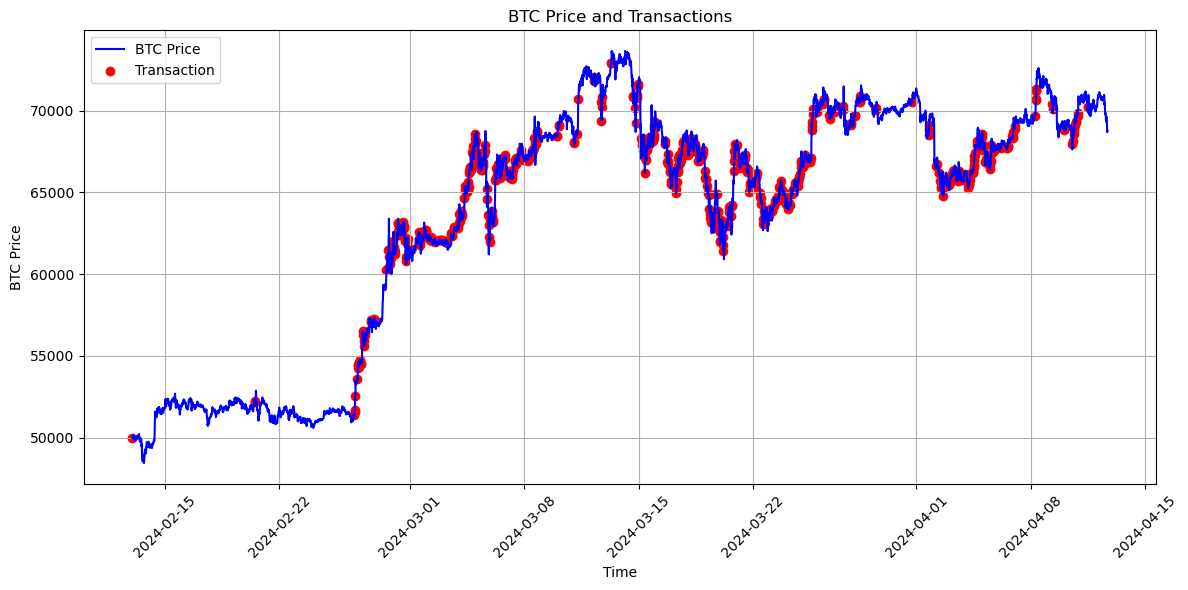

In [5]:
# Calculate final balance
final_balance = balance + (btc_held * current_price)  

# Results
print(f"Final Balance in USD: {final_balance}")  
print(f"Profit/Loss: {final_balance - initial_balance}")  
# Plot transaction timeline
plt.figure(figsize=(12, 6))  
plt.plot(btc_data_15m.index, btc_data_15m['Adj Close'], label='BTC Price', color='blue')  # Plot BTC price
plt.scatter(transaction_times, np.array([btc_data_15m.loc[time]['Adj Close'] for time in transaction_times]), color='red', marker='o', label='Transaction')  # Plot transactions
plt.xlabel('Time')  
plt.ylabel('BTC Price')  
plt.title('BTC Price and Transactions')  
plt.legend()  
plt.grid(True)  # Show grid
plt.xticks(rotation=45)  
plt.tight_layout()  # Adjust layout
plt.show()  

As a result of the imagined trading activities, we first determine the final balance in USD and the accompanying profit or loss. Following that, we graph the price of bitcoin over time and include markers that show the purchase and sell transactions. The following illustration aids in comprehending the trading activity as it relates to changes in the price of bitcoin.

### Analysing Transaction Frequency


In [6]:
# Number of buy and sell transactions
num_buys = transaction_types.count('Buy')
num_sells = transaction_types.count('Sell')

# Total number of transactions
total_transactions = num_buys + num_sells

# Total number of time intervals
total_time_intervals = len(btc_data_15m)

# Frequency of trades (transactions per time interval (15min))
trade_frequency = total_transactions / total_time_intervals

print(f"Number of Buy Transactions: {num_buys}")
print(f"Number of Sell Transactions: {num_sells}")
print(f"Total Transactions: {total_transactions}")
print(f"Total Time Intervals: {total_time_intervals}")
print(f"Trade Frequency: {trade_frequency:.2f} trades per time interval")

Number of Buy Transactions: 333
Number of Sell Transactions: 332
Total Transactions: 665
Total Time Intervals: 5732
Trade Frequency: 0.12 trades per time interval


The code then determines the total number of purchase and sell transactions, trade frequency (transactions per time interval), total number of transactions and total time intervals.

### Determining Trading Period and Average Trades per Day

In [7]:
from datetime import datetime

# Convert strings to datetime objects for calculation
date_format = "%Y-%m-%d %H:%M:%S"
first_trade_date = datetime.strptime(str(btc_data_15m.index[sequence_length]), date_format)
last_trade_date = datetime.strptime(str(btc_data_15m.index[-1]), date_format)

# Total period in days
total_days = (last_trade_date - first_trade_date).days + 1  

total_trades = len(transaction_types)

# Average frequency of trades per day
average_trades_per_day = total_trades / total_days

print(f"Total trades: {total_trades}")
print(f"Total period (days): {total_days}")
print(f"Average trades per day: {average_trades_per_day:.2f}")


Total trades: 665
Total period (days): 60
Average trades per day: 11.08


The code then calculates the average number of trades each day and sets the trading period in days. This data offers insight into trade activities generally for the time under observation.

### Model Evaluation

Test Score: 508.92 RMSE
RSquared : 99.53%


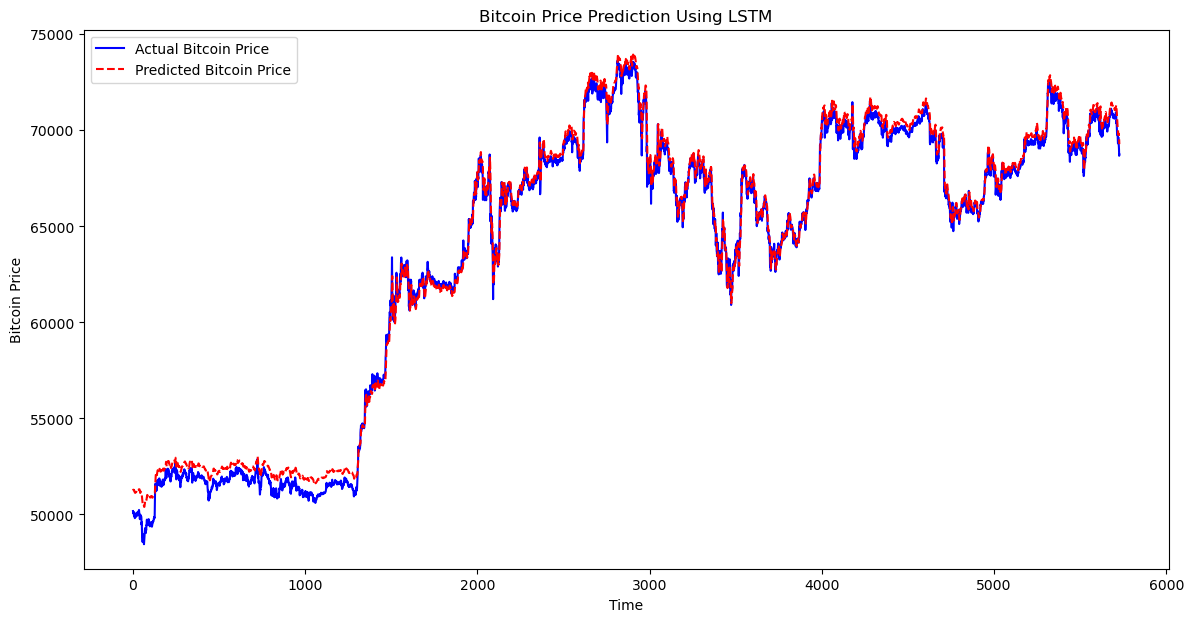

R-squared value: 0.9953


In [8]:
from sklearn.metrics import mean_squared_error, r2_score

testScore = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))  # Calculate test score (RMSE)
print(f'Test Score: {testScore:.2f} RMSE')  # Print test score

r_squared = r2_score(y_test_inv, y_pred_inv)  # Calculate R-squared
print(f'RSquared : {r_squared:.2%}')  # Print R-squared

# Plot the actual vs predicted prices
plt.figure(figsize=(14, 7))  
plt.plot(y_test_inv, color='blue', label='Actual Bitcoin Price')  # Plot actual prices
plt.plot(y_pred_inv, color='red', linestyle='dashed', label='Predicted Bitcoin Price')  # Plot predicted prices
plt.title('Bitcoin Price Prediction Using LSTM') 
plt.xlabel('Time')  
plt.ylabel('Bitcoin Price')  
plt.legend()  
plt.show()  

print(f"R-squared value: {r_squared:.4f}")  # Print R-squared value

The results of these tests offer information about the model's effectiveness and accuracy in forecasting Bitcoin values. Strong predictive power is shown by the high R-squared value, which shows that the model accounts for a significant amount of the variation in the observed data.

The illustration also shows the difference between the expected and actual values of Bitcoin.

# Linear Regression

## Backtesting Linear Regression Trading Model

In [10]:
from joblib import load

btc_data_15m = yf.download(tickers='BTC-USD', period='60d', interval='15m')

features = btc_data_15m[['Open', 'High', 'Low', 'Close']].values

# Scale the features
scaler_features = StandardScaler().fit(features)
features_scaled = scaler_features.transform(features)

target = btc_data_15m['Adj Close'].values.reshape(-1, 1)
scaler_target = StandardScaler().fit(target)
target_scaled = scaler_target.transform(target)

# Load the Linear Regression model
lr_model = load('Final_LR.pkl')

# Make predictions on the scaled features
y_pred_scaled = lr_model.predict(features_scaled)

# Inverse transform to get actual prices
y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Simulate trading
initial_balance = 10000  
balance = initial_balance
btc_held = 0

transaction_times = []  # Store transaction times
transaction_types = []  # Store transaction types

close_prices = btc_data_15m['Close'].values

# Trading Logic
for i in range(len(y_pred)):
    current_price = close_prices[i]
    predicted_price = y_pred[i][0]
    transaction_time = btc_data_15m.index[i]

    if predicted_price > current_price and balance > 0:
        # Buy BTC
        btc_held += balance / current_price
        balance = 0
        print(f"Bought BTC at {current_price} at: {transaction_time}")
        transaction_times.append(transaction_time)
        transaction_types.append('Buy')

    elif predicted_price < current_price and btc_held > 0:
        # Sell BTC
        balance += btc_held * current_price
        btc_held = 0
        print(f"Sold BTC at {current_price} at: {transaction_time}")
        transaction_times.append(transaction_time)
        transaction_types.append('Sell')



[*********************100%***********************]  1 of 1 completed
Bought BTC at 49994.4609375 at: 2024-02-13 00:00:00
Sold BTC at 61046.734375 at: 2024-02-28 17:30:00
Bought BTC at 61387.96484375 at: 2024-02-28 17:45:00
Sold BTC at 60142.9375 at: 2024-02-28 18:15:00
Bought BTC at 60643.66796875 at: 2024-02-28 18:30:00
Sold BTC at 63322.6875 at: 2024-03-04 00:45:00
Bought BTC at 63436.875 at: 2024-03-04 01:00:00
Sold BTC at 66381.96875 at: 2024-03-05 05:00:00
Bought BTC at 67038.609375 at: 2024-03-05 05:15:00
Sold BTC at 66381.234375 at: 2024-03-05 08:00:00
Bought BTC at 66616.046875 at: 2024-03-05 08:15:00
Sold BTC at 68261.84375 at: 2024-03-05 15:00:00
Bought BTC at 67469.09375 at: 2024-03-05 15:15:00
Sold BTC at 65265.8359375 at: 2024-03-05 16:00:00
Bought BTC at 65665.953125 at: 2024-03-05 16:15:00
Sold BTC at 64106.29296875 at: 2024-03-05 17:00:00
Bought BTC at 64578.9765625 at: 2024-03-05 17:15:00
Sold BTC at 62253.19140625 at: 2024-03-05 19:30:00
Bought BTC at 62815.75390625 a

C:\Users\kanso\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


To forecast bitcoin prices, this section makes use of a linear regression model that has already been trained. The scaled features are predicted by the loaded linear regression model. The real price values can be found by later inversion these projections. The next step is to run a trading simulation using the actual and forecasted prices, making decisions to buy or sell at "close" prices. The transactions are saved for analysis together with the corresponding timings.

____

## Calculating Trading Metrics and Analysing Results

### Final Balance and Profit/Loss & Visualising Transactions and BTC Price

Final Balance in USD: 12576.956627359767
Profit/Loss: 2576.9566273597666


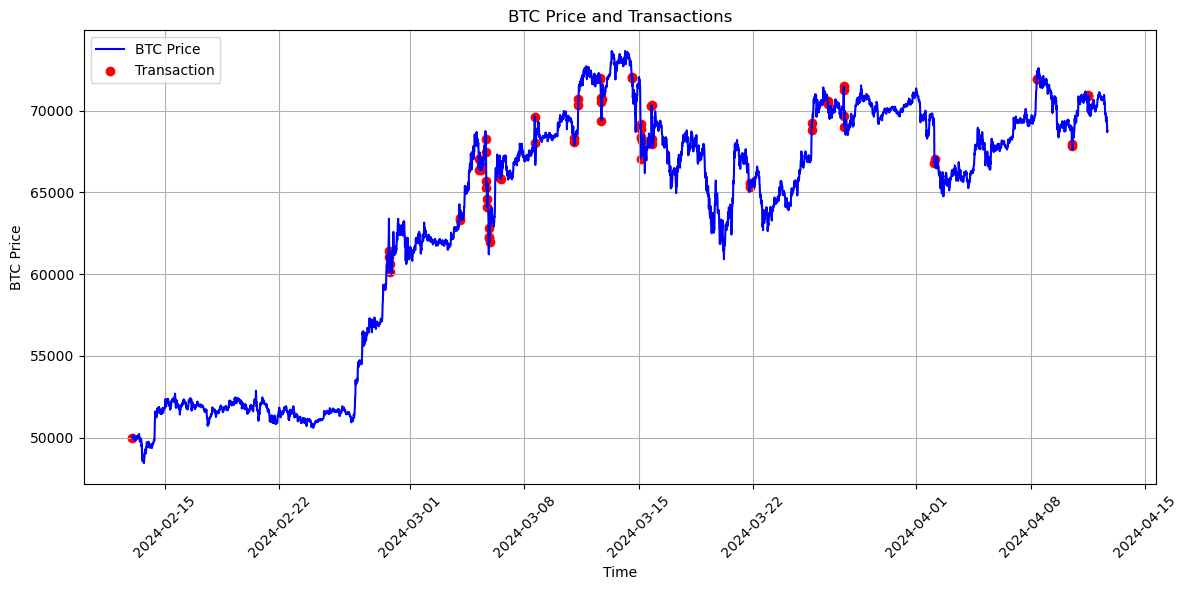

In [11]:
final_balance = balance + (btc_held * current_price)  # Final balance

# Results
print(f"Final Balance in USD: {final_balance}")  
print(f"Profit/Loss: {final_balance - initial_balance}")  

plt.figure(figsize=(12, 6))  
plt.plot(btc_data_15m.index, btc_data_15m['Adj Close'], label='BTC Price', color='blue')  # Plot BTC price
plt.scatter(transaction_times, np.array([btc_data_15m.loc[time]['Adj Close'] for time in transaction_times]), color='red', marker='o', label='Transaction')  # Plot transactions
plt.xlabel('Time')  
plt.ylabel('BTC Price')  
plt.title('BTC Price and Transactions')  
plt.legend()  
plt.grid(True)  # Show grid
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()  

As a result of the imagined trading activities, we first determine the final balance in USD and the accompanying profit or loss. Following that, we graph the price of bitcoin over time and include markers that show the purchase and sell transactions. The following illustration aids in comprehending the trading activity as it relates to changes in the price of bitcoin.

### Analysing Transaction Frequency

In [12]:
num_buys = transaction_types.count('Buy')  #  Number of buy transactions
num_sells = transaction_types.count('Sell')  #  Number of sell transactions

total_transactions = num_buys + num_sells  # Total transactions

total_time_intervals = len(btc_data_15m)  # Total time intervals

trade_frequency = total_transactions / total_time_intervals  # Trade frequency

# Print transaction statistics
print(f"Number of Buy Transactions: {num_buys}")
print(f"Number of Sell Transactions: {num_sells}")
print(f"Total Transactions: {total_transactions}")
print(f"Total Time Intervals: {total_time_intervals}")
print(f"Trade Frequency: {trade_frequency:.2f} trades per time interval")

Number of Buy Transactions: 33
Number of Sell Transactions: 32
Total Transactions: 65
Total Time Intervals: 5732
Trade Frequency: 0.01 trades per time interval


The code then determines the total number of purchase and sell transactions, trade frequency (transactions per time interval), total number of transactions and total time intervals.

### Determining Trading Period and Average Trades per Day

In [13]:
date_format = "%Y-%m-%d %H:%M:%S"

# Get first and last trade dates
first_trade_date = datetime.strptime(str(btc_data_15m.index[sequence_length]), date_format)
last_trade_date = datetime.strptime(str(btc_data_15m.index[-1]), date_format)

# Total days
total_days = (last_trade_date - first_trade_date).days + 1  

total_trades = len(transaction_types)  # Total trades

average_trades_per_day = total_trades / total_days  # Average trades per day

# Trading period statistics
print(f"Total trades: {total_trades}")
print(f"Total period (days): {total_days}")
print(f"Average trades per day: {average_trades_per_day:.2f}")

Total trades: 65
Total period (days): 60
Average trades per day: 1.08


The code then calculates the average number of trades each day and sets the trading period in days. This data offers insight into trade activities generally for the time under observation.

_____

## Feature Preparation for Different Models
As a result of their underlying mathematical processes and architectures, different models have different needs for data inputs. This has an impact on the features that are selected for backtesting linear regression and LSTM models.

## LSTM Model

We focus on the application of modified closing prices for the LSTM model:


'features = btc_data_15m['Adj Close'].values.reshape(-1, 1)'

- The 'Adj Close' prices are chosen from our dataset, btc_data_15m. By accounting for stock splits and dividends, "Adj Close" offers a more accurate representation of Bitcoin's price fluctuations independent of outside factors.

- In order to meet the input specifications of LSTM models, the data is shaped. Because LSTM models depend on time-series forecasting, the data must be transformed into a two-dimensional array with one feature per sample using the reshape(-1, 1) command.

## Linear Regression Model
For the Linear Regression model a combination of price indicators is used:

'features = btc_data_15m[['Open', 'High', 'Low', 'Close']].values'

- A wider range of characteristics, such as "Open," "High," "Low," and "Close" prices, are used in this model. To capture the whole range of price swings throughout each trading interval, financial models often include these elements.

- No reshaping is required; the features are transformed straight to a numpy array. This format fits with scikit-learn's linear regression model's input specifications, which call for each sample to have numerous features that correspond to various price indications.

## Summary
The way that each model prepares its data is in line with the type of predictions it is intended to produce and the particular criteria for each input:

- LSTM: Developed for sequential data processing, this model requires single-feature input that has been reshaped at each time step.

- Linear Regression: This model may take into account several pricing points because it is made to handle numerous characteristics at once.

#### By making sure every model receives data in the proper format, these preparation techniques maximise each model's performance for the specific prediction job.

____

## References

- **yfinance**, no date. yfinance is a library that provides easy access to the Yahoo Finance API for fetching historical market data. Available at: [https://pypi.org/project/yfinance/](https://pypi.org/project/yfinance/).

- **Chollet, F.** and others, 2015. Keras. Available at: [https://keras.io](https://keras.io).

- **Harris, C.R., Millman, K.J., van der Walt, S.J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., et al.**, 2020. Array programming with NumPy. *Nature*, 585(7825), pp.357-362. Available at: [https://doi.org/10.1038/s41586-020-2649-2](https://doi.org/10.1038/s41586-020-2649-2).

- **McKinney, W.**, 2010. Data Structures for Statistical Computing in Python. In: Proceedings of the 9th Python in Science Conference. pp.51-56. Available at: [https://conference.scipy.org/proceedings/scipy2010/mckinney.html](https://conference.scipy.org/proceedings/scipy2010/mckinney.html).

- **Hunter, J.D.**, 2007. Matplotlib: A 2D graphics environment. *Computing in Science & Engineering*, 9(3), pp.90-95. Available at: [https://doi.org/10.1109/MCSE.2007.55](https://doi.org/10.1109/MCSE.2007.55).

- **Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., et al.**, 2011. Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, pp.2825-2830. Available at: [http://jmlr.org/papers/v12/pedregosa11a.html](http://jmlr.org/papers/v12/pedregosa11a.html).

- **Bao, W., Yue, J. & Rao, Y. (2017)** 'A deep learning framework for financial time series using stacked autoencoders and long-short term memory', *PLOS ONE*, 12(7), e0180944. Available at: [https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0180944](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0180944).

- **Chong, E., Han, C. & Park, F.C. (2017)** 'Deep learning networks for stock market analysis and prediction: Methodology, data representations, and case studies', *Expert Systems with Applications*, 83, pp. 187-205. Available at: [https://www.sciencedirect.com/science/article/pii/S0957417417301600](https://www.sciencedirect.com/science/article/pii/S0957417417301600).

- **Heaton, J.B., Polson, N.G. & Witte, J.H. (2017)** 'Deep learning for finance: deep portfolios', *Applied Stochastic Models in Business and Industry*, 33(1), pp. 3-12. Available at: [https://onlinelibrary.wiley.com/doi/abs/10.1002/asmb.2209](https://onlinelibrary.wiley.com/doi/abs/10.1002/asmb.2209).

- **Krauss, C., Do, X.A. & Huck, N. (2017)** 'Deep neural networks, gradient-boosted trees, random forests: Statistical arbitrage on the S&P 500', *European Journal of Operational Research*, 259(2), pp. 689-702. Available at: [https://www.sciencedirect.com/science/article/pii/S0377221716303470](https://www.sciencedirect.com/science/article/pii/S0377221716303470).

- **Dixon, M.F., Klabjan, D. & Bang, J.H. (2020)** 'Classification-based financial markets prediction using deep neural networks', *Algorithmic Finance*, 8(3-4), pp. 147-160. Available at: [https://content.iospress.com/articles/algorithmic-finance/af190015](https://content.iospress.com/articles/algorithmic-finance/af190015).
